In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt

import tensorflow as tf
print(tf. __version__)

import matplotlib
cmap_NN = matplotlib.colormaps['Reds']
cmap_RMSA = matplotlib.colormaps['Blues']

2.10.0


## Load model

In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
from RMSA import RMSA
q_rs = (np.arange(80)+1)*0.2
def SQ_RMSA(parameters):
    return (RMSA(q_rs, 0.5, scl=parameters[1], gamma=parameters[2], eta=parameters[0]))[1]

## Define functions

In [3]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Load data

In [4]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


### resolution

In [5]:
# from scipy.io import loadmat
# filename_EQSANS = './EQSANS.mat'
# loaded_EQSANS = loadmat(filename_EQSANS)
# q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
# qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
# data = loaded_EQSANS['data']#.astype('float32')
# qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
# q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
# qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

data_EQSANS = np.loadtxt('./EQSANS.txt',delimiter=',',skiprows=2)
q_EQSANS_0 = data_EQSANS[:,0]#.astype('float32')
qsig_EQSANS = data_EQSANS[:,3]#.astype('float32')
IQ_EQSANS = data_EQSANS[:,1]#.astype('float32')
E_EQSANS = data_EQSANS[:,2]#.astype('float32')

qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

## Select data and produce I(Q)

In [6]:
print('\neta in')
print(np.unique(eta))
print('\nkappa in')
print(np.unique(kappa))
print('\nA in')
print(np.unique(A))


eta in
[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]

kappa in
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]

A in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [7]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(eta-parameters[0])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    id_A = np.abs(A-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

In [8]:
eta_list = np.array([0.045,0.135,0.225,0.315,0.405])
kappa_list = np.array([0.1,0.2,0.3,0.4,0.5])
A_list = np.array([1,3,6,10,20])

In [9]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp


In [10]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)    

from scipy.special import lambertw as lambertw
def xV(A,kappa):
    return kappa*lambertw(A/kappa*np.exp(1/kappa))
            
def log_Aeta(A,kappa,eta):
    r_eta = (np.pi/6*eta)**(-1/3)
    return np.log(A) - np.log(r_eta) + (-(r_eta-1)/kappa)

def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

def xV_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dxV_dA = (xV(A*(1+delta),kappa)-xV(A,kappa))/(A*delta)
    dxV_dkappa = (xV(A,kappa*(1+delta))-xV(A,kappa))/(kappa*delta)
    
    xV_err = np.sqrt((dxV_dA*A_err)**2 + (dxV_dkappa*kappa_err)**2)
    return xV_err

def log_Aeta_err(A,kappa,eta,A_err,kappa_err,eta_err,delta = 1e-3):
    dy_dA = (log_Aeta(A*(1+delta),kappa,eta)-log_Aeta(A,kappa,eta))/(A*delta)
    dy_dkappa = (log_Aeta(A,kappa*(1+delta),eta)-log_Aeta(A,kappa,eta))/(kappa*delta)
    dy_deta = (log_Aeta(A,kappa,eta*(1+delta))-log_Aeta(A,kappa,eta))/(eta*delta)
    
    y_err = np.sqrt((dy_dA*A_err)**2 + (dy_dkappa*kappa_err)**2 + (dy_deta*eta_err)**2)
    return y_err

## eta

In [11]:
parameters_list = np.array([[eta_list[i],kappa_list[2],A_list[2]] for i in range(len(eta_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [12]:
dict_eta = {'fp_GT_list':fp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,}

## kappa

In [13]:
parameters_list = np.array([[eta_list[2],kappa_list[i],A_list[2]] for i in range(len(kappa_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [14]:
dict_kappa = {'fp_GT_list':fp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,}

## A

In [15]:
parameters_list = np.array([[eta_list[2],kappa_list[2],A_list[i]] for i in range(len(A_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [16]:
dict_A = {'fp_GT_list':fp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,}

# Plot results

In [38]:
markers = ['o','x','s','+','^']

## eta

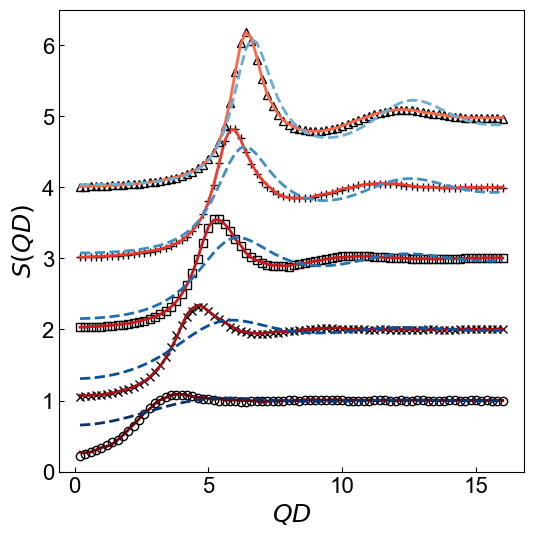

In [39]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]

    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    SQ_exp_GT = dict_eta['SQ_exp_GT_list'][i]+i
    SQ_exp_NN = SQ_NN(fp_GT)+i
    SQ_exp_RMSA = SQ_RMSA(fp_GT)+i

#     ax.plot(q,SQ_exp_GT,
#             '-k', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_GT,
            markers[i], color='k', fillstyle='none', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,SQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$S(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
# ax.set_yscale('log')
ax.set_ylim([0,6.5])

plt.show()

## kappa

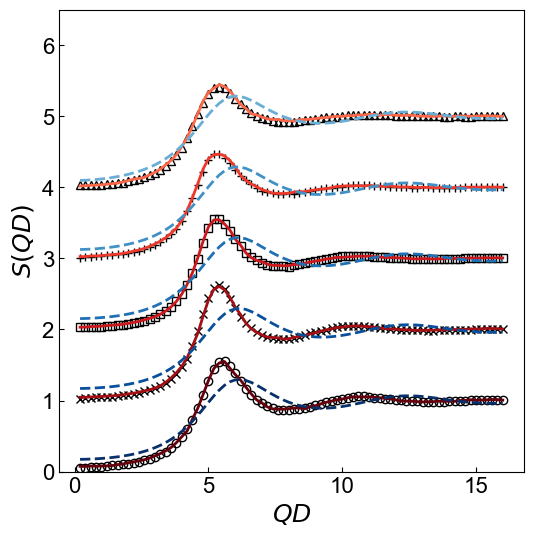

In [40]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]+i
    SQ_exp_NN = SQ_NN(fp_GT)+i
    SQ_exp_RMSA = SQ_RMSA(fp_GT)+i

#     ax.plot(q,SQ_exp_GT,
#             '-k', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_GT,
            markers[i], color='k', fillstyle='none', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,SQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$S(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
# ax.set_yscale('log')
ax.set_ylim([0,6.5])

plt.show()

## A

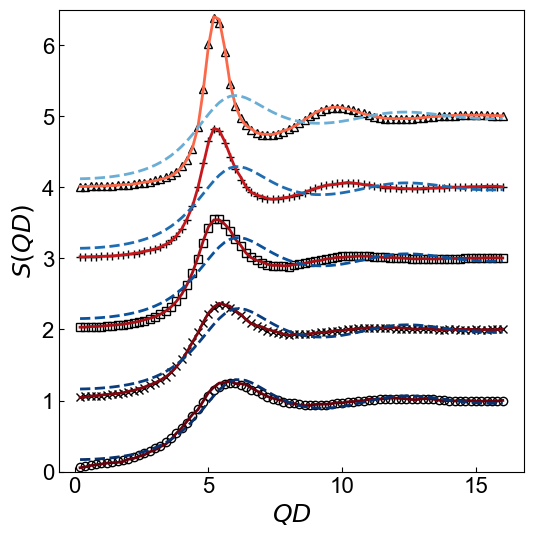

In [41]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    SQ_exp_GT = dict_A['SQ_exp_GT_list'][i]+i
    SQ_exp_NN = SQ_NN(fp_GT)+i
    SQ_exp_RMSA = SQ_RMSA(fp_GT)+i

#     ax.plot(q,SQ_exp_GT,
#             '-k', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_GT,
            markers[i], color='k', fillstyle='none', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,SQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$S(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
# ax.set_yscale('log')
ax.set_ylim([0,6.5])

plt.show()

## fitting curve and residual

In [47]:
from scipy.io import loadmat
from glob import glob

def load_SQ_MD(filename):
    data = np.genfromtxt(filename)
    n_particles = 16384
    Q_data = data[10:,0]
    SQ_data = data[10:,1]*n_particles

    f_interp = interp.interp1d(Q_data,SQ_data,kind='nearest',fill_value='extrapolate')
    SQ_MD = f_interp(q)
    
    return SQ_MD

### eta

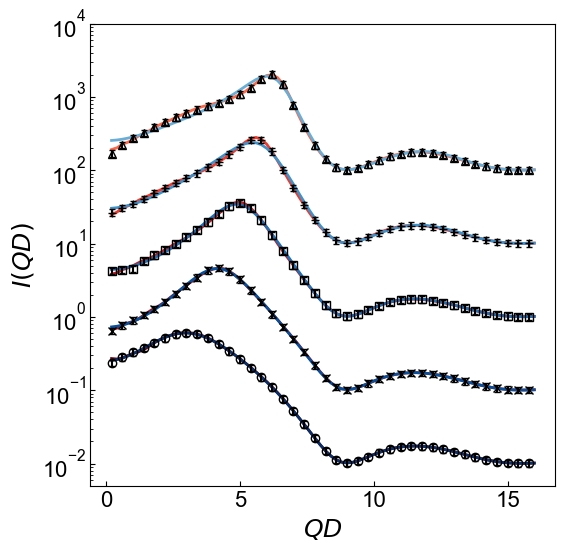

In [126]:
# NN and RMSA fitting curve
dict_eta = loadmat('fp_eta.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
#     ax.plot(q,IQ_MD*10**i,
#             ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
            label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

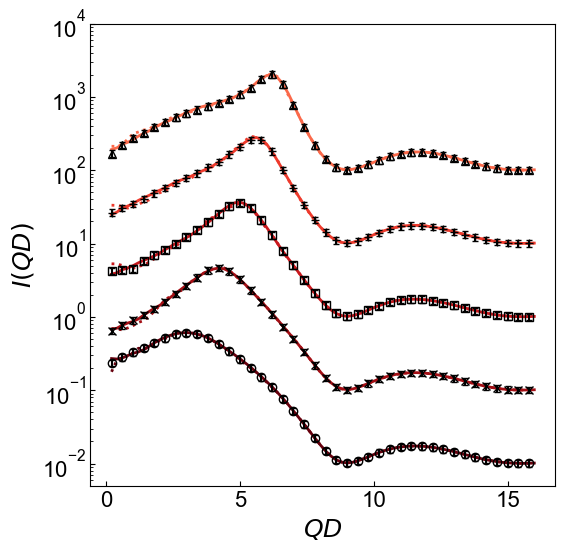

In [123]:
# NN fitting curve and MD invertion
dict_eta = loadmat('fp_eta.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

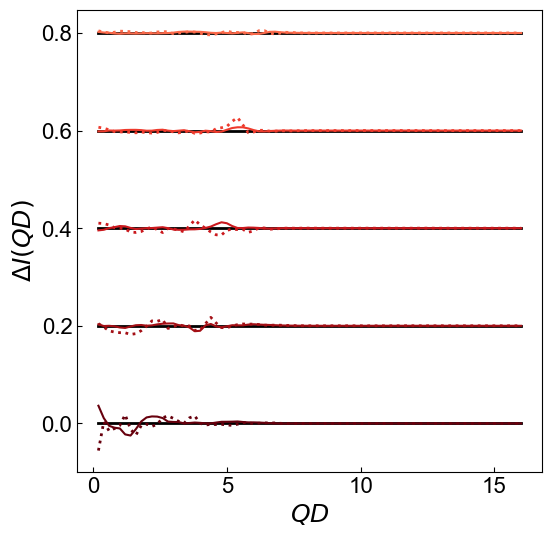

In [110]:
# NN fitting curve and MD invertion: residual
dict_eta = loadmat('fp_eta.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    shift = 0.2
    ax.plot(q,IQ_exp_GT-IQ_exp_GT+i*shift,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD-IQ_exp_GT+i*shift,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT+i*shift,'-',
            label='NN', color=c_NN)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
#             label='RMSA', color=c_RMSA)

#     ax.plot(q[index_q],IQ_exp_GT[index_q]*0+i*shift,
#             markers[i], color='k', fillstyle='none', lw=2, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*0+i*shift,IQ_exp_GT[index_q]*0.01,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$\Delta I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

### kappa

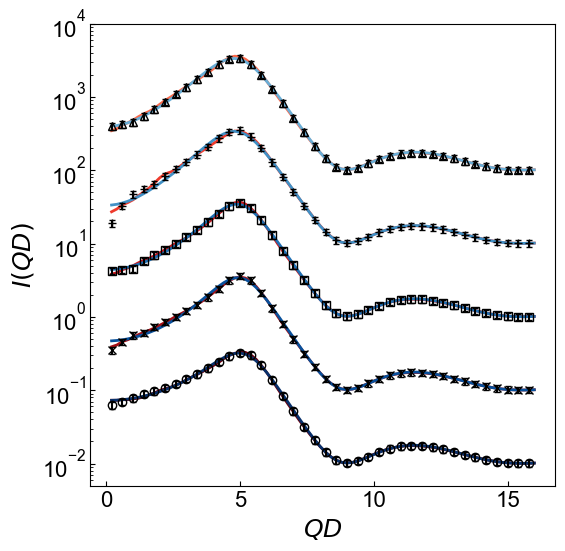

In [127]:
# NN and RMSA fitting curve
dict_kappa = loadmat('fp_kappa.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
#     ax.plot(q,IQ_MD*10**i,
#             ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
            label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

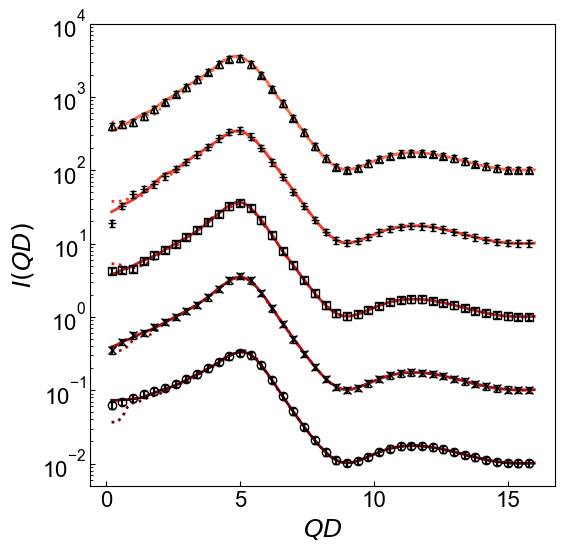

In [124]:
# NN fitting curve and MD invertion
dict_kappa = loadmat('fp_kappa.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

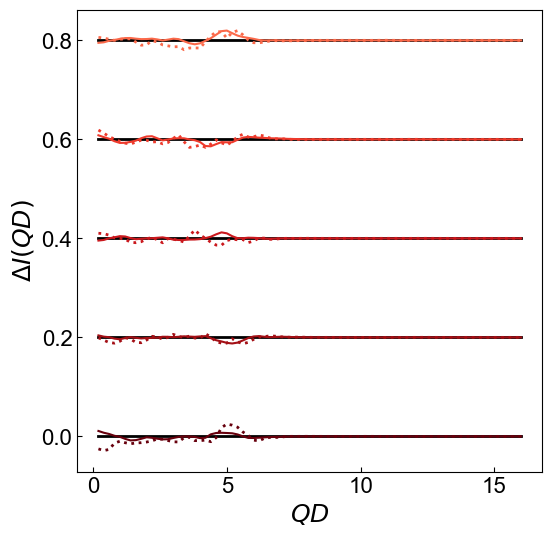

In [111]:
# NN fitting curve and MD invertion: residual
dict_kappa = loadmat('fp_kappa.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    shift = 0.2
    ax.plot(q,IQ_exp_GT-IQ_exp_GT+i*shift,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD-IQ_exp_GT+i*shift,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT+i*shift,'-',
            label='NN', color=c_NN)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
#             label='RMSA', color=c_RMSA)

#     ax.plot(q[index_q],IQ_exp_GT[index_q]*0+i*shift,
#             markers[i], color='k', fillstyle='none', lw=2, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*0+i*shift,IQ_exp_GT[index_q]*0.01,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$\Delta I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

### A

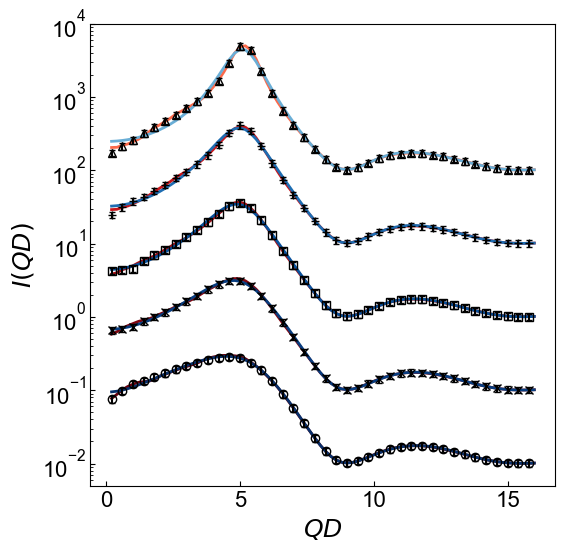

In [128]:
# NN and RMSA fitting curve
dict_A = loadmat('fp_A.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
#     ax.plot(q,IQ_MD*10**i,
#             ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
            label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

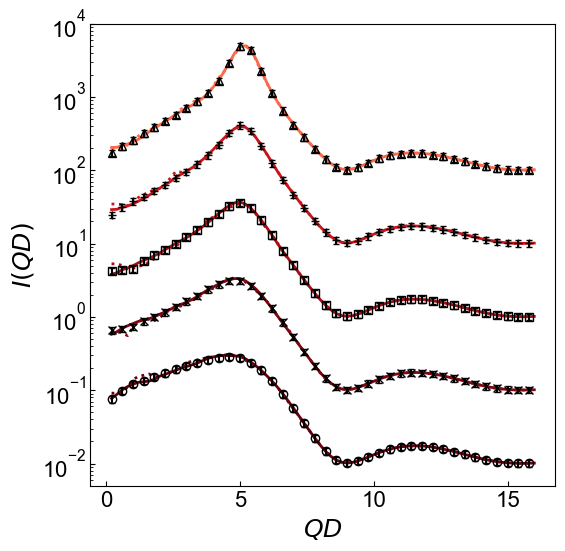

In [125]:
# NN fitting curve and MD invertion
dict_A = loadmat('fp_A.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

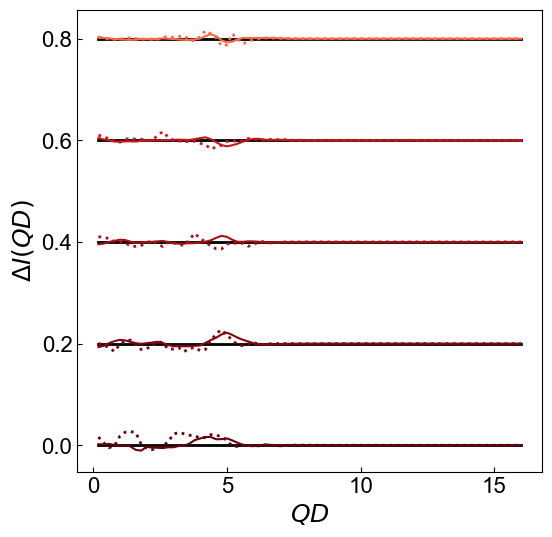

In [112]:
# NN fitting curve and MD invertion: residual
dict_A = loadmat('fp_A.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    shift = 0.2
    ax.plot(q,IQ_exp_GT-IQ_exp_GT+i*shift,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD-IQ_exp_GT+i*shift,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT+i*shift,'-',
            label='NN', color=c_NN)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
#             label='RMSA', color=c_RMSA)

#     ax.plot(q[index_q],IQ_exp_GT[index_q]*0+i*shift,
#             markers[i], color='k', fillstyle='none', lw=2, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*0+i*shift,IQ_exp_GT[index_q]*0.01,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$\Delta I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

## Inverted V(r)

In [30]:
rr = np.linspace(0.01, 2.0, 200)
ur_hc = 4*500*((2**(1/6)/rr)**12-(2**(1/6)/rr)**6-0.25)
ur_hc[rr>=1] = 0

def sample_potential(fp,fp_err):
    n_sample = 100
    
    kappa = fp[1]
    kappa_std = fp_err[1]
    A = fp[2]
    A_std = fp_err[2]
    
    ur_sample = np.zeros((tf.size(rr),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        A_sample = np.random.normal()*(A_std) + A
        ur_sample[:,i] = A_sample*np.exp(-(rr-1)/kappa_sample)/rr + ur_hc
        
    ur_std = np.std(ur_sample,axis=1)
    ur_mean = np.mean(ur_sample,axis=1)
        
    return ur_mean, ur_std

def sample_potential_GT(fp):
    kappa = fp[1]
    A = fp[2]
    
    ur = A*np.exp(-(rr-1)/kappa)/rr + ur_hc
        
    return ur

### eta

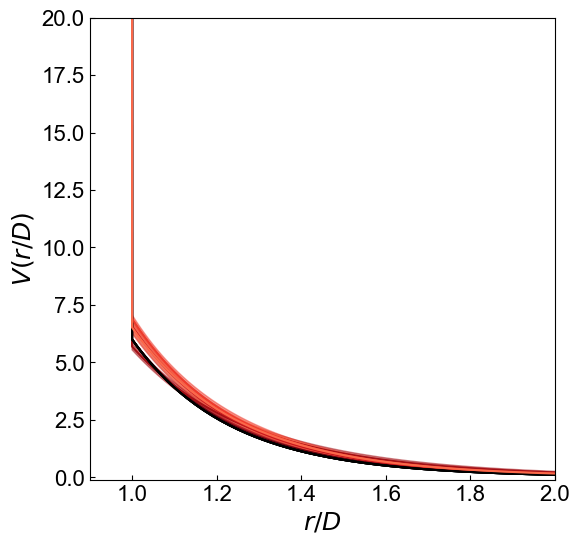

In [31]:
# V(r)
dict_eta = loadmat('fp_eta.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_eta['fp_err_NN_list'][i]
    fp_err_RMSA = dict_eta['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color=c_NN,alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color=c_NN)

ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$',fontsize=18)
ax.set_ylabel(r'$V(r/D)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

### kappa

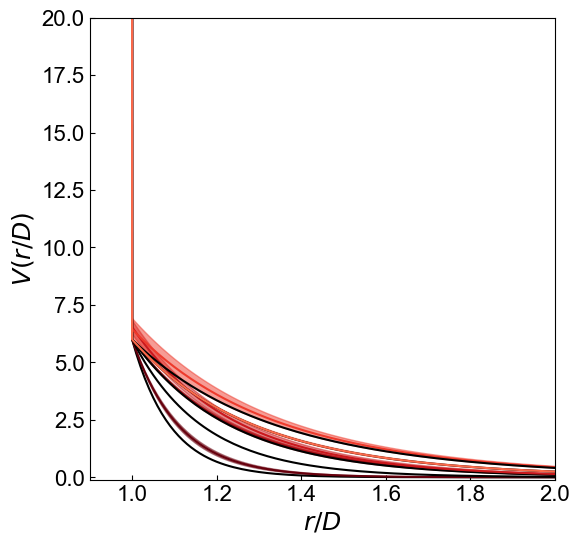

In [32]:
# V(r)
dict_kappa = loadmat('fp_kappa.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color=c_NN,alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color=c_NN)

ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$',fontsize=18)
ax.set_ylabel(r'$V(r/D)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

### A

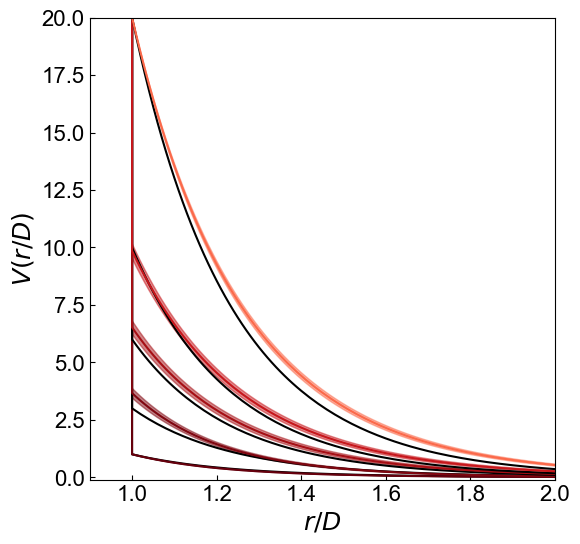

In [33]:
# V(r)
dict_A = loadmat('fp_A.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_A['fp_err_NN_list'][i]
    fp_err_RMSA = dict_A['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color=c_NN,alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color=c_NN)

ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$',fontsize=18)
ax.set_ylabel(r'$V(r/D)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

## overlapped I(Q)

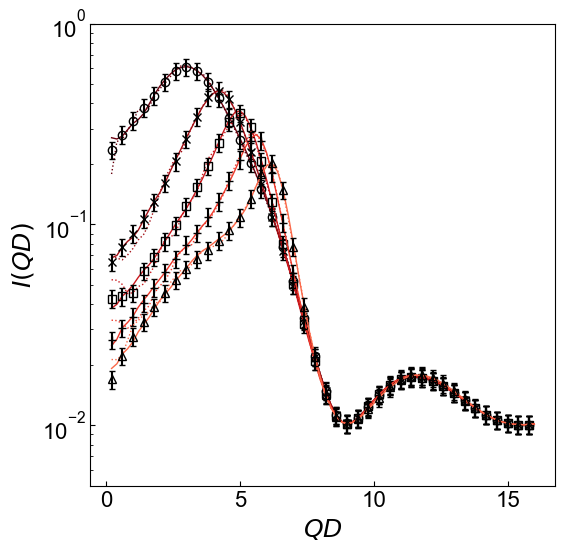

In [121]:
# eta, overlapped
# NN fitting curve and MD invertion
dict_eta = loadmat('fp_eta.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*1**i,
            ':', lw=1, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
            label='NN', color=c_NN, lw=1)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
            markers[i], color='k', fillstyle='none', lw=1, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

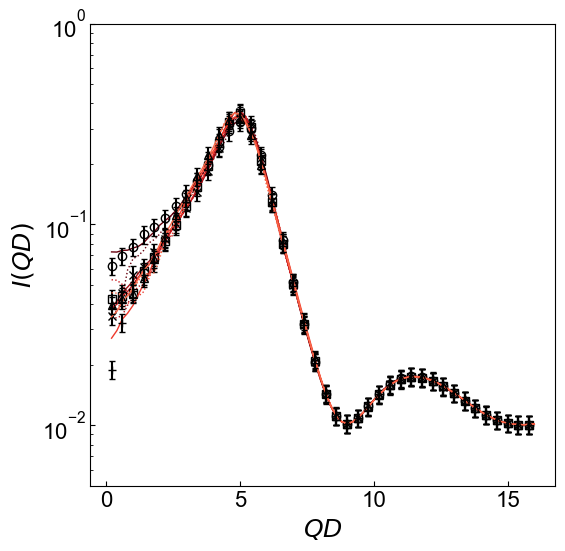

In [120]:
# kappa, overlapped
# NN fitting curve and MD invertion
dict_kappa = loadmat('fp_kappa.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*1**i,
            ':', lw=1, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
            label='NN', color=c_NN, lw=1)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
            markers[i], color='k', fillstyle='none', lw=1, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

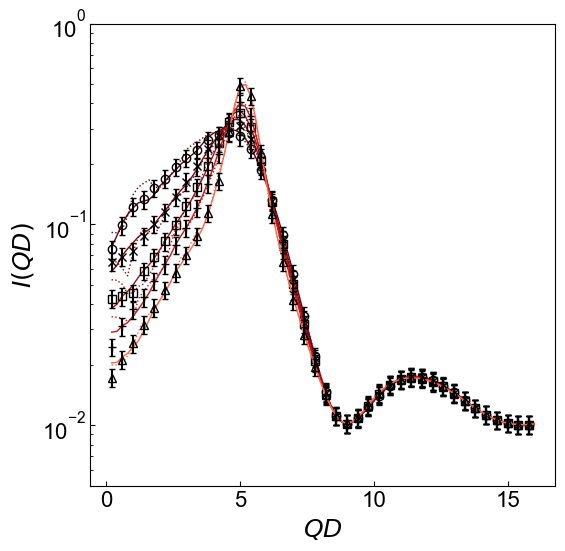

In [129]:
# A, overlapped
# NN fitting curve and MD invertion
dict_A = loadmat('fp_A.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*1**i,
            ':', lw=1, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
            label='NN', color=c_NN, lw=1)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
            markers[i], color='k', fillstyle='none', lw=1, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()